In [1]:
# Including Libraries

In [1]:
import dask.dataframe as dd#similar to pandas
import pandas as pd#pandas to create small dataframes 
import folium#open street map
import datetime#Convert to unix time
import time#Convert to unix time
import numpy as np#Do aritmetic operations on arrays
import seaborn as sns#Plots
import matplotlib.pylab as plt#Plots
import matplotlib  #Plots
from matplotlib import rcParams#Size of plots  
import gpxpy.geo#Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Reading training data

In [2]:
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# Data Cleaning

## 1. Pickup Latitude and Longitude

In [3]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
#creating default map object

sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

NameError: name 'month' is not defined

## 2. Dropoff Latitude and Longitude

In [8]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['dropoff_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

## 3. Trip Duration

In [4]:
# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert this string to python time format and then into unix time stamp
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

#we return a dataframe which contains the columns
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    print(type(duration))
    print(type(duration_pickup))  
    
    #compute duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup)) / float(60)
    
    #append duration of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60 * (new_frame['trip_distance'] / new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

<class 'pandas.core.frame.DataFrame'>
<class 'list'>


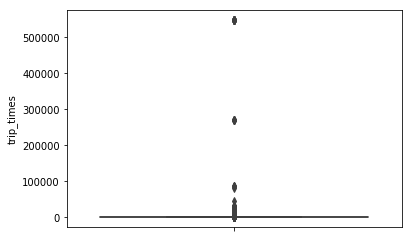

In [11]:
#box plot showing the presence of outliers
sns.boxplot(y = "trip_times", data = frame_with_durations)
plt.show()

In [12]:
#calculation the 0 to 100th percentile to find the threshold for removal of outliers
for i in range(0,100,10) :
    var = frame_with_durations['trip_times'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ", var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [13]:
#looking further deep into 90th percentile
for i in range(90,100):
    var = frame_with_durations['trip_times'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [14]:
#looking further deep into 99th percentile
for i in np.arange(0.0,1.0,0.1):
    var = frame_with_durations['trip_times'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99 + i,var[int(len(var) * (float(99 + i) / 100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 46.75
99.1 percentile value is 48.06666666666667
99.2 percentile value is 49.56666666666667
99.3 percentile value is 51.28333333333333
99.4 percentile value is 53.31666666666667
99.5 percentile value is 55.833333333333336
99.6 percentile value is 59.13333333333333
99.7 percentile value is 63.9
99.8 percentile value is 71.86666666666666
99.9 percentile value is 101.6
100 percentile value is  548555.6333333333


In [5]:
#removing data based on 12 hrs of trip duration
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times > 1) & (frame_with_durations.trip_times <= 720)]

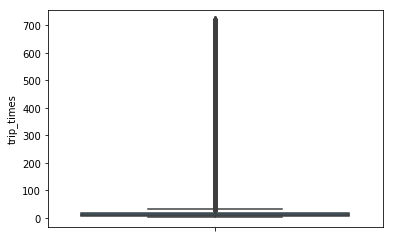

In [16]:
#box plot after removal of outliers
sns.boxplot(y = "trip_times", data = frame_with_durations_modified)
plt.show()

## 4. Speed

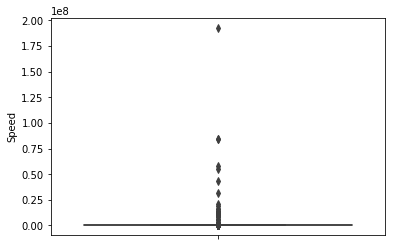

In [11]:
#check for outliers in the data after trip duration outliers are removed
#box plot for speed with outliers
frame_with_durations_modified['Speed'] = 60 * (frame_with_durations_modified['trip_distance'] / frame_with_durations_modified['trip_times'])
sns.boxplot(y = "Speed", data = frame_with_durations_modified)
plt.show()

In [18]:
#calculating speed at 0-100th percentile
for i in range(0,100,10) :
    var = frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [19]:
#looking further deep into 90th percentile to determine threshold value
for i in range(90,100) :
    var = frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [20]:
#looking further deep into 99th percentile to determine threshold value
for i in np.arange(0.0,1.0,0.1) :
    var = frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99 + i,var[int(len(var) * (float(99 + i) / 100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [6]:
#removing outliers based on thr 99.9th percentile
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.Speed > 0) & (frame_with_durations_modified.Speed <= 45.31)]

In [13]:
#avg. speed of cabs in NYC
sum(frame_with_durations_modified.Speed) / float(len(frame_with_durations_modified.Speed))

12.452320837813998

The avg speed of cabs is 12.45 miles/hr, so a cab can travel 2 miles per 10 mins on average.

## 5. Trip Distance

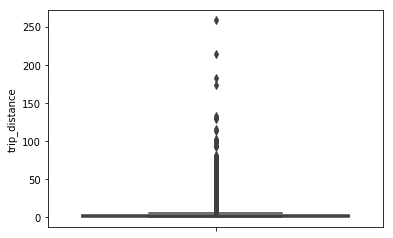

In [23]:
#removing outliers based on trip distance
#visualizing the outliers
sns.boxplot(y = "trip_distance", data = frame_with_durations_modified)
plt.show()

In [24]:
#calculating the values at 0-100th percentile for trip distance
for i in range(0,100,10) :
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ", var[-1])

0 percentile value is 0.01
10 percentile value is 0.67
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.7
60 percentile value is 2.08
70 percentile value is 2.61
80 percentile value is 3.6
90 percentile value is 5.98
100 percentile value is  258.9


In [25]:
#looking further deep into the 90-100th percentile values
for i in range(90,100) :
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 5.98
91 percentile value is 6.47
92 percentile value is 7.09
93 percentile value is 7.87
94 percentile value is 8.74
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.06
99 percentile value is 18.18
100 percentile value is  258.9


In [26]:
#looking further deep into the 99th percentile values to determine the threshold value of trip distance
for i in np.arange(0.0,1.0,0.1) :
    var = frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99 + i,var[int(len(var) * (float(99 + i) / 100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 18.18
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.84
99.4 percentile value is 19.14
99.5 percentile value is 19.5
99.6 percentile value is 19.97
99.7 percentile value is 20.51
99.8 percentile value is 21.23
99.9 percentile value is 22.58
100 percentile value is  258.9


In [7]:
#removing the outliers based on the 99.9th percentile value of trip distance
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.trip_distance > 0) & (frame_with_durations_modified.trip_distance < 23)]

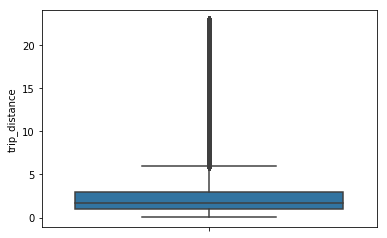

In [28]:
#boxplot after removal of outliers
sns.boxplot(y = "trip_distance", data = frame_with_durations_modified)
plt.show()

We kept the threshold value for trip distance as 23 miles

## 5. Total Fare

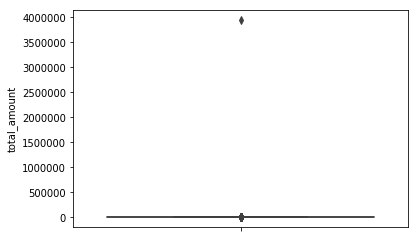

In [29]:
#box plot to visualize the outliers of total fare
sns.boxplot(y = 'total_amount', data = frame_with_durations_modified)
plt.show()

In [30]:
#calulating total fare amount value for 0-100th percentile
for i in range(0,100,10) :
    var = frame_with_durations_modified['total_amount'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.35
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [31]:
#looking further into the 90-100th percentile values
for i in range(90,100) :
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i) / 100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.13
93 percentile value is 31.55
94 percentile value is 34.63
95 percentile value is 38.13
96 percentile value is 42.13
97 percentile value is 47.53
98 percentile value is 57.68
99 percentile value is 65.8
100 percentile value is  3950611.6


In [32]:
#looking further into the 99th percentile values to determine the threshold values for total_amount
for i in np.arange(0.0,1.0,0.1) :
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99 + i,var[int(len(var) * (float(99 + i) / 100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 65.8
99.1 percentile value is 67.55
99.2 percentile value is 68.8
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.73
99.6 percentile value is 69.76
99.7 percentile value is 72.46
99.8 percentile value is 75.16
99.9 percentile value is 86.6
100 percentile value is  3950611.6


As even the 99.9th percentile value doesnot look like an outlier,we perform graphical analysis

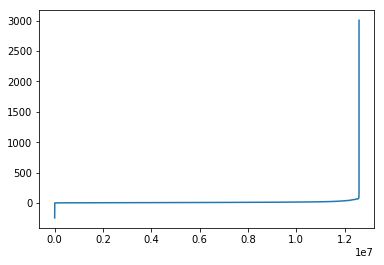

In [33]:
#ploting the fare amount excluding the last two values in sorted data
plt.plot(var[:-2])
plt.show()

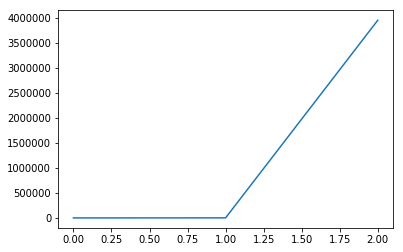

In [34]:
#plotting the last three values show sharp increase in total amount
plt.plot(var[-3:])
plt.show()

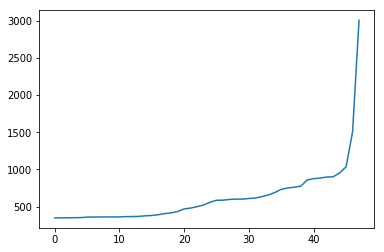

In [35]:
#plotting the last 50 values excluding the last 2 values
plt.plot(var[-50:-2])
plt.show()

Therefore we take the threshold value for total_amount as 1000 dollars

In [8]:
#removing the outilers
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.total_amount > 0) & (frame_with_durations_modified.total_amount < 1000)]

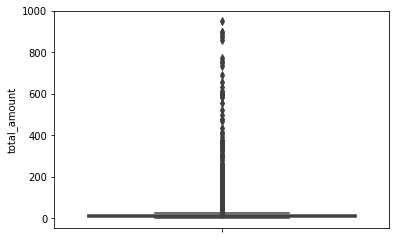

In [37]:
#boxplot after removal of outliers
sns.boxplot(y = "total_amount", data = frame_with_durations_modified)
plt.show()

## Removal of Outliers/Erronous points

In [9]:
#removing all outliers based on our analysis
def remove_outliers(new_frame) :
    a = new_frame.shape[0]
    print("Number of pickup records = ", a)
    
    #removing trips lying outside the latitude and longitude
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    #removing trips lying outside 12 hrs of trip_duration
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    #removing outliers having trip_distance > 23 miles
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    #removing outliers having speed > 45.31
    temp_frame = new_frame[(new_frame.Speed <= 45.31) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    #removing outliers having total_amount > 1000 dollars
    temp_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame    

In [11]:
print("Removing the outliers: ")
print("-----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers = ", float(len(frame_with_durations_outliers_removed)/len(frame_with_durations)))

Removing the outliers: 
-----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 36690
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers =  0.9703576425607495


# Clustering

In [12]:
#trying with different cluster sizes to choose the right k in K-Means
coords = frame_with_durations_outliers_removed[['pickup_latitude','pickup_longitude']].values
neighbours = []

def find_min_distance(cluster_centers, cluster_len) :
    pos_points = 0
    neg_points = 0
    less2 = []
    more2 = []
    min_dist = 1000
    for i in range(0,cluster_len) :
        pos_points = 0
        neg_points = 0
        for j in range(0,cluster_len) :
            if j != i :
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0],cluster_centers[i][1],cluster_centers[j][0],cluster_centers[j][1])
                min_dist = min(min_dist,distance / (1.60934 * 1000))
                if (distance / (1.60934 * 1000)) <= 2 :
                    pos_points += 1
                else :
                    neg_points += 1
        less2.append(pos_points)
        more2.append(neg_points)
    neighbours.append(less2)
    print("On choosing a cluster size of ",cluster_len,"\nAvg. number of clusters within the vicinity (i.e. intercluster distance < 2) : ", np.ceil(sum(less2)/len(less2)),\
            "\nAvg. number of clusters outside the vicinity (i.e. intercluster distance > 2) : ",np.ceil(sum(more2)/len(more2)), \
             "\nMin inter-cluster distance = ", min_dist, "\n-----")
    
def find_clusters(k) :
    kmeans = MiniBatchKMeans(n_clusters = k, batch_size = 10000,random_state = 42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude','pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers,cluster_len

for i in range(10,100,10) :
    cluster_centers,cluster_len = find_clusters(i)
    find_min_distance(cluster_centers,cluster_len)

On choosing a cluster size of  10 
Avg. number of clusters within the vicinity (i.e. intercluster distance < 2) :  2.0 
Avg. number of clusters outside the vicinity (i.e. intercluster distance > 2) :  8.0 
Min inter-cluster distance =  1.0945442325142543 
-----
On choosing a cluster size of  20 
Avg. number of clusters within the vicinity (i.e. intercluster distance < 2) :  4.0 
Avg. number of clusters outside the vicinity (i.e. intercluster distance > 2) :  16.0 
Min inter-cluster distance =  0.7131298007387813 
-----
On choosing a cluster size of  30 
Avg. number of clusters within the vicinity (i.e. intercluster distance < 2) :  8.0 
Avg. number of clusters outside the vicinity (i.e. intercluster distance > 2) :  22.0 
Min inter-cluster distance =  0.5185088176172206 
-----


KeyboardInterrupt: 

In [20]:
#temporary
coords = jan_2015_frame[['pickup_latitude','pickup_longitude']].values

In [13]:
#choosing k = 40 for sloving the further problem
kmeans = MiniBatchKMeans(n_clusters = 40, batch_size = 10000, random_state = 0).fit(coords)
#frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [20]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

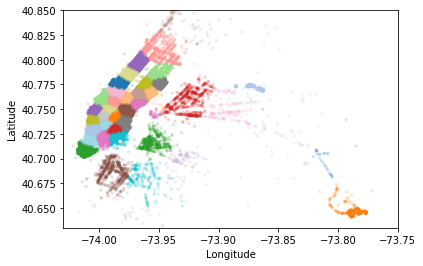

In [21]:
#Visualising the clusters on the map
def plot_clusters(frame) :
    city_long_border = (-74.03,-73.75)
    city_lat_border = (40.63,40.85)
    fig, ax = plt.subplots(ncols = 1, nrows = 1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

# Time-Binning

In [14]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [15]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)

#we add two more columns 'pickup_cluster'(to which cluster it belongs to) and 'pickup_bins'(to which 10 min interval the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


In [ ]:
jan_2015_frame.to_csv("aln.csv", sep = ',')

In [16]:
#trip_distance represent the number of pickups that happened in that particular 10min interval
#this dataframe has two indices
#primary index : pickup_cluster (cluster number) & secondary index : pickup_bins
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

We divide the whole months time into 10 min intervals (31 x 24 x 60 / 10 = 4464 bins)

In [17]:
jan_2015_frame = pd.read_csv('aln.csv')
jan_2015_frame.drop(jan_2015_frame.columns[0],axis = 1,inplace = True)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


# Data Preperation

In [18]:
#data preperation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    frame_with_durations = return_with_trip_times(month)
    print("Removing outliers...")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print("Estimating clusters...")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude','pickup_longitude']])
    
    print("Final groupbying...")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
#loading jan_2016 data and preparing the data
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
Removing outliers...
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 31018
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters...
Final groupbying...


In [19]:
#loading feb_2016 data and preparing the data
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
Removing outliers...
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 31866
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters...
Final groupbying...


In [20]:
#loading mar_2016 data and preparing the data
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
Removing outliers...
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers from trip times analysis: 30868
Number of outliers from trip distance analysis: 87318
Number of outliers from speed analysis: 33076
Number of outliers from fare analysis: 5859
Total outliers removed 324635
---
Estimating clusters...
Final groupbying...


## Smoothing

In [21]:
#there are some pickup_bins for which there are no pickups that is why smoothing is required
#returning the unique bins where pickup values are present for each cluster
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [22]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [23]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [24]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [25]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [26]:
#Filling Missing values of Jan-2015 with 0
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

number of 10min intravels among all the clusters  178560


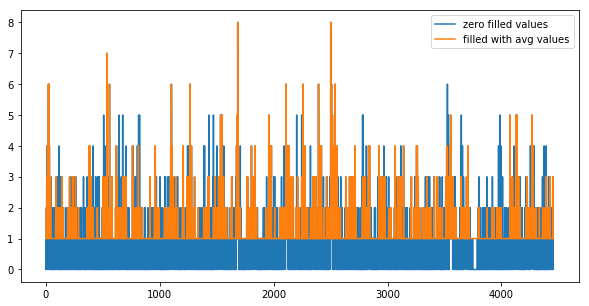

In [57]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [27]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

In [29]:
jan_2016 = np.array(jan_2016_smooth)
print(jan_2016.shape)

(178560,)


In [35]:
jan_2015_smooth_df = pd.DataFrame(jan_2015_smooth)
jan_2016_smooth_df = pd.DataFrame(jan_2016_smooth)
feb_2016_smooth_df = pd.DataFrame(feb_2016_smooth)
mar_2016_smooth_df = pd.DataFrame(mar_2016_smooth)
jan_2015_smooth_df.to_csv('jan_2015_smooth.csv', sep = ',')
jan_2016_smooth_df.to_csv('jan_2016_smooth.csv', sep = ',')
feb_2016_smooth_df.to_csv('feb_2016_smooth.csv', sep = ',')
mar_2016_smooth_df.to_csv('mar_2016_smooth.csv', sep = ',')

# Modeling

## Baseline Models

In [59]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

## Simple Moving Average
#### Using Ratios

In [60]:
## Simple Moving average
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

#### Using Previous Values

In [61]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## Weighted Moving Average

#### Using Ratios

In [62]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

#### Using Previous Values

In [63]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## Exponential Weighted Moving Average

#### Using Ratios

In [64]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

#### Using Previous Values

In [65]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [66]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

#comparing the baseline models
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1821155173392136       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849686975506        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1784869254376018       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.13551088436182082       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17783550194861494       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526

In [30]:
# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

In [41]:
print(len(jan_2016_smooth))

178560


In [31]:
print(len(regions_cum))
print(len(regions_cum[0]))

40
13104


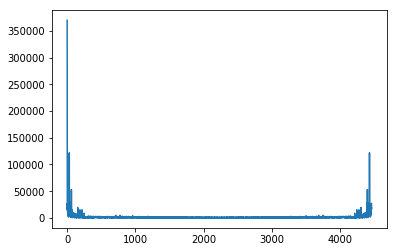

(121826.78062703028, 31) (52806.64057259263, 62)
0.006944444444444444 0.013888888888888888


In [176]:
amp_jan = np.abs(np.fft.fft(regions_cum[0][:4464]))
freq_jan = np.abs(np.fft.fftfreq(4464,1))
#np.sort(amp_jan)
i = 0
list_amp = []
for amp in amp_jan :
    list_amp.append((amp,i))
    i = i + 1
plt.plot(amp_jan)
plt.show()
list_amp.sort()
print(list_amp[-2],list_amp[-4])
print(freq_jan[list_amp[-2][1]],freq_jan[list_amp[-4][1]])

In [179]:
def create_list(amp_month) :
    list_month = []
    i = 0
    for amp in amp_month :
        list_month.append((amp,i))
        i += 1
    list_month.sort()
    return list_month

In [181]:
freq_jan = np.abs(np.fft.fftfreq(4464,1))
freq_feb = np.abs(np.fft.fftfreq(4176,1))
freq_mar = np.abs(np.fft.fftfreq(4464,1))
amp_jan_list = []
amp_feb_list = []
amp_mar_list = []
freq_jan_list = []
freq_feb_list = []
freq_mar_list = []
for i in range(0,40) :
    amp_jan = np.sort(np.abs(np.fft.fft(regions_cum[i][:4464])))
    amp_feb = np.sort(np.abs(np.fft.fft(regions_cum[i][4464:8640])))
    amp_mar = np.sort(np.abs(np.fft.fft(regions_cum[i][8640:])))
    list_jan = create_list(amp_jan)
    list_feb = create_list(amp_feb)
    list_mar = create_list(amp_mar)
    inner_list_amp_jan = []
    inner_list_amp_feb = []
    inner_list_amp_mar = []
    inner_list_freq_jan = []
    inner_list_freq_feb = []
    inner_list_freq_mar = []
    inner_list_amp_jan.append(list_jan[-2][0])
    inner_list_amp_jan.append(list_jan[-4][0])
    inner_list_amp_feb.append(list_feb[-2][0])
    inner_list_amp_feb.append(list_feb[-4][0])
    inner_list_amp_mar.append(list_mar[-2][0])
    inner_list_amp_mar.append(list_mar[-4][0])
    inner_list_freq_jan.append(freq_jan[list_jan[-2][1]])
    inner_list_freq_jan.append(freq_jan[list_jan[-4][1]])
    inner_list_freq_feb.append(freq_feb[list_feb[-2][1]])
    inner_list_freq_feb.append(freq_feb[list_feb[-4][1]])
    inner_list_freq_mar.append(freq_mar[list_mar[-2][1]])
    inner_list_freq_mar.append(freq_mar[list_mar[-4][1]])
    amp_jan_list.append(inner_list_amp_jan)
    amp_feb_list.append(inner_list_amp_feb)
    amp_mar_list.append(inner_list_amp_mar)
    freq_jan_list.append(inner_list_freq_jan)
    freq_feb_list.append(inner_list_freq_feb)
    freq_mar_list.append(inner_list_freq_mar)
print(len(amp_jan_list))
print(len(amp_jan_list[0]))
print(len(freq_jan_list))
print(len(freq_jan_list[0]))

40
2
40
2


In [182]:
print(amp_jan_list[0][0])
print(freq_jan_list[0][0])

121826.78062703028
0.00044802867383512545


In [183]:
amp_1 = []
amp_2 = []
freq_1 = []
freq_2 = []
for i in range(0,40) :
    inner_amp_1 = []
    inner_amp_2 = []
    inner_freq_1 = []
    inner_freq_2 = []
    inner_amp_1.append([amp_jan_list[i][0]]*4454)
    inner_amp_2.append([amp_jan_list[i][1]]*4454)
    inner_freq_1.append([freq_jan_list[i][0]]*4454)
    inner_freq_2.append([freq_jan_list[i][1]]*4454)
    inner_amp_1.append([amp_feb_list[i][0]]*4176)
    inner_amp_2.append([amp_feb_list[i][1]]*4176)
    inner_freq_1.append([freq_feb_list[i][0]]*4176)
    inner_freq_2.append([freq_feb_list[i][1]]*4176)
    inner_amp_1.append([amp_mar_list[i][0]]*4464)
    inner_amp_2.append([amp_mar_list[i][1]]*4464)
    inner_freq_1.append([freq_mar_list[i][0]]*4464)
    inner_freq_2.append([freq_mar_list[i][1]]*4464)
    amp_1.append(inner_amp_1)
    amp_2.append(inner_amp_2)
    freq_1.append(inner_freq_1)
    freq_2.append(inner_freq_2)
for i in range(0,40) :
    amp_1[i] = sum(amp_1[i], [])
    amp_2[i] = sum(amp_2[i], [])
    freq_1[i] = sum(freq_1[i], [])
    freq_2[i] = sum(freq_2[i], [])
print(len(freq_1))
print(len(freq_1[0]))

40
13094


In [184]:
# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 10

# output varaible
# it is list of lists
# it will contain number of pickups 13094 for each cluster
output = []


# tsne_lat will contain 13104-10=13094 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13094times],[cent_lat 13094times], [cent_lat 13094times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-10=13094 times logitude of cluster center for every cluster
# Ex: [[cent_long 13094times],[cent_long 13094times], [cent_long 13094times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numpy array, of shape (523960, 10)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4,f5,f6,f7...,f9] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5,..,f10]
# the third row will have [f2,f3,f4,f5,f6,...,f11]
# and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13094)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13094)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(10,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][10:])
tsne_feature = tsne_feature[1:]

In [63]:
print(tsne_feature)
print(tsne_feature.shape)

[[  0  63 217 ... 150 164 152]
 [ 63 217 189 ... 164 152 131]
 [217 189 137 ... 152 131 138]
 ...
 [109  92 117 ...  82  87  97]
 [ 92 117  91 ...  87  97 106]
 [117  91  80 ...  97 106 105]]
(523760, 10)


In [64]:
print(len(tsne_lat[0]),",",len(tsne_lat))
print(tsne_feature.shape[0])

13094 , 40
523760


In [65]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13094 == len(output)*len(output[0])

True

In [185]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[10:])
    predicted_values=[]

In [95]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [186]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13094:(13094*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13094*(i))+9169:13094*(i+1)] for i in range(0,40)]

In [100]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 10 features
Number of data clusters 40 Number of data points in test data 3925 Each data point contains 10 features


In [187]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_amp1 = [i[:9169] for i in amp_1]
tsne_train_amp2 = [i[:9169] for i in amp_2]
tsne_train_freq1 = [i[:9169] for i in freq_1]
tsne_train_freq2 = [i[:9169] for i in freq_2]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [188]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_amp1 = [i[9169:] for i in amp_1]
tsne_test_amp2 = [i[9169:] for i in amp_2]
tsne_test_freq1 = [i[9169:] for i in freq_1]
tsne_test_freq2 = [i[9169:] for i in freq_2]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [189]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [190]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_amp1 = sum(tsne_train_amp1, [])
tsne_train_amp2 = sum(tsne_train_amp2, [])
tsne_train_freq1 = sum(tsne_train_freq1, [])
tsne_train_freq2 = sum(tsne_train_freq2, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [191]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_amp1 = sum(tsne_test_amp1, [])
tsne_test_amp2 = sum(tsne_test_amp2, [])
tsne_test_freq1 = sum(tsne_test_freq1, [])
tsne_test_freq2 = sum(tsne_test_freq2, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [192]:
print(len(tsne_train_lat))
print(len(tsne_train_freq1))

366760
366760


In [193]:
# Preparing the data frame for our train data
columns = ['ft_10','ft_9','ft_8','ft_7','ft_6','ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['freq_1'] = tsne_train_freq1
df_train['freq_2'] = tsne_train_freq2
df_train['amp_1'] = tsne_train_amp1
df_train['amp_2'] = tsne_train_amp2
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 18)


In [194]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['freq_1'] = tsne_test_freq1
df_test['freq_2'] = tsne_test_freq2
df_test['amp_1'] = tsne_test_amp1
df_test['amp_2'] = tsne_test_amp2
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] =tsne_test_exp_avg
print(df_test.shape)

(157000, 18)


In [195]:
df_test.head()

,ft_10,ft_9,ft_8,ft_7,ft_6,ft_5,ft_4,ft_3,ft_2,ft_1,freq_1,freq_2,amp_1,amp_2,lat,lon,weekday,exp_avg
0,118,106,104,93,102,101,120,131,164,154,0.000448,0.000896,123762.512777,70368.355736,40.776228,-73.982119,4,153
1,106,104,93,102,101,120,131,164,154,133,0.000448,0.000896,123762.512777,70368.355736,40.776228,-73.982119,4,139
2,104,93,102,101,120,131,164,154,133,148,0.000448,0.000896,123762.512777,70368.355736,40.776228,-73.982119,4,145
3,93,102,101,120,131,164,154,133,148,172,0.000448,0.000896,123762.512777,70368.355736,40.776228,-73.982119,4,163
4,102,101,120,131,164,154,133,148,172,153,0.000448,0.000896,123762.512777,70368.355736,40.776228,-73.982119,4,156


In [196]:
tsne_train_out = pd.DataFrame(tsne_train_output)
tsne_test_out = pd.DataFrame(tsne_test_output)
df_train.to_csv('X_train_new3.csv', sep = ',')
df_test.to_csv('X_test_new3.csv',sep = ',')
tsne_train_out.to_csv('Y_train_new3.csv',sep = ',')
tsne_test_out.to_csv('Y_test_new3.csv',sep = ',')

In [197]:
df_train.drop([df_train.columns[0],df_train.columns[1],df_train.columns[2],df_train.columns[3],df_train.columns[4]],axis = 1,inplace = True)
df_test.drop([df_test.columns[0],df_test.columns[1],df_test.columns[2],df_test.columns[3],df_test.columns[4]],axis = 1,inplace = True)
print(df_train.head())

   ft_5  ft_4  ft_3  ft_2  ft_1    freq_1    freq_2          amp_1  \
0   135   129   150   164   152  0.000448  0.000896  121826.780627   
1   129   150   164   152   131  0.000448  0.000896  121826.780627   
2   150   164   152   131   138  0.000448  0.000896  121826.780627   
3   164   152   131   138   147  0.000448  0.000896  121826.780627   
4   152   131   138   147   127  0.000448  0.000896  121826.780627   

          amp_2        lat        lon  weekday  exp_avg  
0  52806.640573  40.776228 -73.982119        4      153  
1  52806.640573  40.776228 -73.982119        4      137  
2  52806.640573  40.776228 -73.982119        4      137  
3  52806.640573  40.776228 -73.982119        4      144  
4  52806.640573  40.776228 -73.982119        4      132  


## Random Forest

In [198]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [199]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [200]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'freq_1', 'freq_2', 'amp_1',
       'amp_2', 'lat', 'lon', 'weekday', 'exp_avg'],
      dtype='object')
[0.07424502 0.08711719 0.17215115 0.21533768 0.1916566  0.00025927
 0.00026095 0.01863554 0.01414222 0.00327041 0.00150914 0.00145266
 0.21996217]


In [201]:
print(mean_absolute_error(tsne_test_output, rndf_test_predictions))
print(sum(tsne_test_output))
print(len(tsne_test_output))

8.365808917197452
10445989
157000


In [166]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [167]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.14008057196824064       Test:  0.136559592394746
Exponential Averages Forecasting -           Train:  0.13291801284208646       Test:  0.1293682197061475
Random Forest Regression -                   Train:  0.09194699616618707      Test:  0.12591253925310472
